# Load Waterlevel

In [54]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import lxml

In [55]:
LOWER_MEKONG_STATION_CODES =  [
    "STR", # StungTreng
    "KRA", # Kratie
    "KOM", # Kompong Cham
    "PPB", # Phnom Penh (Bassac)
    "PPP", # Phnom Penh Port
    "KOH", # Koh Khel (Bassac)
    "NEA", # Neak Luong
    "PRE", # Prek Kdam (Tonle Sap)
    "TCH", # Tan Chau
    "CDO", # Chau Doc (Bassac)
]
BASE_URL = "http://ffw.mrcmekong.org/fetchwet_st.php?StCode="
r = requests.get(BASE_URL+LOWER_MEKONG_STATION_CODES[3], verify=False)
# soup = BeautifulSoup(r.content, 'html5lib')
# body = soup.find('body')
data_string = r.content.decode('utf-8')

# Convert single quotes and remove any non-JSON parts
data_string = data_string.replace('date_gmt:', '"date_gmt":')
data_string = data_string.replace('Max:', '"Max":')
data_string = data_string.replace('Min:', '"Min":')
data_string = data_string.replace('AVG:', '"AVG":')
data_string = data_string.replace('floodLevel:', '"floodLevel":')
data_string = data_string.replace('alarmLevel:', '"alarmLevel":')
for year in range(1992, 2025):
    data_string = data_string.replace(f'{year}:', f'"{year}":')

data_string = data_string.replace(',]', ']')

# Now parse it into a list of dictionaries
data = json.loads(data_string)

# Convert to dataframe
df = pd.DataFrame(data)
df['date_gmt'] = df['date_gmt'].apply(lambda x: x.split("-")[1]+"-"+x.split("-")[2])
df['station'] = LOWER_MEKONG_STATION_CODES[3]

# Set date_gmt as index 
df.index = df['date_gmt']

df.describe()

/home/vscode/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ffw.mrcmekong.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,Max,Min,AVG,1992,1998,2000,2016,2017,2018,2019,2020,2021,2022,2023,2024,floodLevel,alarmLevel
count,153.000000,153.0,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.0,153.0
mean,9.479281,0.0,7.140654,6.269608,5.489020,9.092484,5.459869,7.036275,7.262484,4.709412,4.009477,4.709281,6.199608,5.300261,4.926667,12.0,10.5
std,1.792758,0.0,2.184002,2.262871,1.771895,1.952256,2.049587,1.856611,2.555734,2.435415,1.792308,1.689127,2.031904,2.354565,2.864221,0.0,0.0
min,4.900000,0.0,2.690000,2.040000,2.420000,4.700000,1.940000,3.550000,2.590000,1.990000,1.640000,1.760000,3.240000,0.000000,0.000000,12.0,10.5
25%,8.240000,0.0,5.290000,4.400000,4.760000,7.620000,4.150000,4.670000,4.190000,2.420000,2.270000,3.220000,3.840000,2.670000,2.150000,12.0,10.5
50%,10.390000,0.0,8.140000,6.910000,5.810000,9.760000,5.640000,8.130000,8.140000,4.070000,4.170000,4.730000,6.790000,6.280000,6.260000,12.0,10.5
75%,10.770000,0.0,9.000000,8.340000,6.870000,10.490000,7.420000,8.440000,9.600000,6.630000,5.360000,6.380000,7.840000,7.430000,7.100000,12.0,10.5
max,11.200000,0.0,9.450000,9.010000,7.920000,11.200000,8.130000,8.860000,9.950000,9.490000,7.700000,7.560000,9.220000,8.260000,9.100000,12.0,10.5


# Preprocess Waterlevel

In [56]:
# Assuming df is your original DataFrame
df_filtered = df[['date_gmt', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']]
df_filtered.set_index('date_gmt', inplace=True)
df_filtered.reset_index(inplace=True)

# Melt the DataFrame to long format
df_long = pd.melt(df_filtered, id_vars=['date_gmt'], value_vars=['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'],
                   var_name='Year', value_name='water_level')

# Combine the date and year into a single column and convert to datetime
df_long['DATE_GMT'] = pd.to_datetime(df_long['date_gmt'] + '-' + df_long['Year'], format='%m-%d-%Y')

# Interpolate
df_long['water_level'] = df_long['water_level'].replace(0, np.nan).interpolate()

# Filter using the correct date comparison
df_waterlevel = df_long[df_long['DATE_GMT'] <= '2024-08-31']

# Drop the 'Year' and lowercase 'date_gmt' columns
df_waterlevel.drop(columns=['Year', 'date_gmt'], inplace=True)

# Set the index to 'DATE_GMT'
df_waterlevel.set_index('DATE_GMT', inplace=True)

# Display the resulting DataFrame
df_waterlevel


/tmp/ipykernel_26039/3942074224.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_waterlevel.drop(columns=['Year', 'date_gmt'], inplace=True)


,water_level
DATE_GMT,
2016-06-01,2.020
2016-06-02,2.040
2016-06-03,2.020
2016-06-04,2.040
2016-06-05,2.100
...,...
2024-08-27,6.315
2024-08-28,6.330
2024-08-29,6.390


# Load Rainfall

In [57]:
csv_path = '/workspaces/project-water/src/data/rainfall.csv'
df_rainfall = pd.read_csv(csv_path)
df_rainfall['DATE_GMT'] = pd.to_datetime(df_rainfall['DATE_GMT'])
df_rainfall = df_rainfall[df_rainfall['DATE_GMT'] >= '2016-06-01']

df_rainfall.set_index('DATE_GMT', inplace=True)
df_rainfall

/tmp/ipykernel_26039/633192792.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_rainfall['DATE_GMT'] = pd.to_datetime(df_rainfall['DATE_GMT'])


,precipitation
DATE_GMT,
2016-06-01,2.201
2016-06-02,0.725
2016-06-03,5.293
2016-06-04,7.405
2016-06-05,8.050
...,...
2024-08-27,10.591
2024-08-28,11.959
2024-08-29,6.123


# Merge Data

In [58]:
df_rainfall.index = pd.to_datetime(df_rainfall.index)
df_waterlevel.index = pd.to_datetime(df_waterlevel.index)

merged_df = df_waterlevel.join(df_rainfall, how='inner')
merged_df
# merged_df.plot(figsize=(12,6))

,water_level,precipitation
DATE_GMT,,
2016-06-01,2.020,2.201
2016-06-02,2.040,0.725
2016-06-03,2.020,5.293
2016-06-04,2.040,7.405
2016-06-05,2.100,8.050
...,...,...
2024-08-27,6.315,10.591
2024-08-28,6.330,11.959
2024-08-29,6.390,6.123


# Train

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping


train = merged_df.iloc[:1222]
test = merged_df.iloc[1222:]

# Scale the data (fit on train data)
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)


look_back = 10
batch_size = 32  # Batch size


train_X = scaled_train
train_y = scaled_train[:, 0]           

test_X = scaled_test
test_y = scaled_test[:, 0]


# Create TimeseriesGenerator for training and testing data
train_generator = TimeseriesGenerator(train_X, train_y, length=look_back, batch_size=batch_size)
test_generator = TimeseriesGenerator(test_X, test_y, length=look_back, batch_size=batch_size)


model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, train_X.shape[1])))
model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(train_generator, 
                    validation_data=test_generator, 
                    epochs=100, 
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/100


/home/vscode/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4897

/home/vscode/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4588 - val_loss: 0.0503
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0605 - val_loss: 0.0083
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0107 - val_loss: 0.0040
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 0.0050
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0036
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_loss: 0.0029
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0029
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0038
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 - val_loss: 0.0026
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - val_loss: 0.0031
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - val_lo

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6300e-04 


Test Loss: 0.00036755541805177927
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


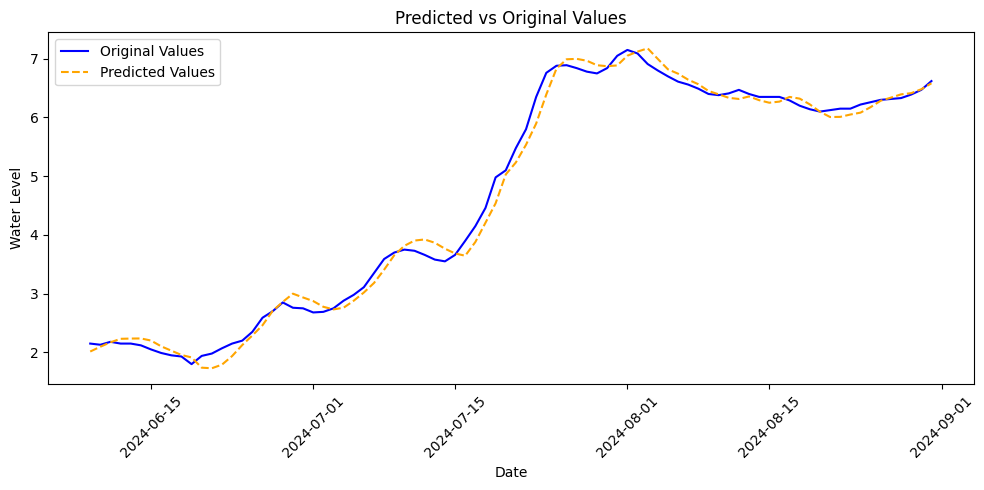

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Evaluate the model
loss = model.evaluate(test_generator)
print(f"Test Loss: {loss}")

# Get predictions
predictions = model.predict(test_generator)

# Prepare predictions for inverse transformation
predictions_scaled = np.zeros((len(predictions), scaled_test.shape[1]))
predictions_scaled[:, 0] = predictions.squeeze()

# Get the actual test data (excluding the look_back)
test_data = scaled_test[look_back:]

# Inverse transform the predicted and original data
predictions_inverse = scaler.inverse_transform(predictions_scaled)
original_test_data_inverse = scaler.inverse_transform(test_data)

# Extract the water level data
original_mean_waterlevel = original_test_data_inverse[:, 0]
predicted_mean_waterlevel = predictions_inverse[:, 0]

# Generate test dates based on your index
test_dates = merged_df.index[1222 + look_back:1222 + len(predictions) + look_back]

# Plot predicted vs original values with dates
plt.figure(figsize=(10, 5))
plt.plot(test_dates, original_mean_waterlevel, label='Original Values', color='blue')
plt.plot(test_dates, predicted_mean_waterlevel, label='Predicted Values', linestyle='dashed', color='orange')
plt.title('Predicted vs Original Values')
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [61]:
df_rainfall_inference = df_rainfall.last('20D').first('10D')
df_waterlevel_inference = df_waterlevel.last('20D').first('10D')
new_data = df_waterlevel_inference.join(df_rainfall_inference, how='inner')


# Scale the new data
scaled_new_data = scaler.transform(new_data)
scaled_new_data.shape


# Initialize variables for forecasting
look_back = 10
num_days_to_forecast = 5
predicted_values = []

# Create a copy of the scaled new data to avoid modifying the original
scaled_data_for_forecast = scaled_new_data.copy()

for i in range(num_days_to_forecast):
    # Use the last 'look_back' steps to predict the next water level
    input_data = scaled_data_for_forecast[-look_back:].reshape(1, look_back, 2)
    
    # Predict the next water level (scaled)
    predicted_scaled = model.predict(input_data)
    
    # Inverse transform the prediction (combine with 0 rainfall for inverse transform)
    predicted_water_level = scaler.inverse_transform(np.hstack([predicted_scaled, np.zeros((1, 1))]))[0, 0]
    
    # Append the predicted water level (not scaled) to the list
    predicted_values.append(predicted_water_level)
    
    # Update the scaled data for the next iteration
    # Create a new "scaled" row with the predicted water level and assume 0 rainfall
    new_row_scaled = np.hstack([predicted_scaled[0], 0]).reshape(1, -1)
    
    # Add this new row to the scaled data for the next prediction
    scaled_data_for_forecast = np.vstack([scaled_data_for_forecast, new_row_scaled])

# Print the predicted water levels for the next 7 days
for i, pred in enumerate(predicted_values):
    forecast_date = df_waterlevel_inference.index[-1] + pd.Timedelta(days=i+1)
    print(f"Predicted Water Level on {forecast_date}: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/tmp/ipykernel_26039/677358099.py:1: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df_rainfall_inference = df_rainfall.last('20D').first('10D')
/tmp/ipykernel_26039/677358099.py:1: FutureWarning: first is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df_rainfall_inference = df_rainfall.last('20D').first('10D')
/tmp/ipykernel_26039/677358099.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df_waterlevel_inference = df_waterlevel.last('20D').first('10D')
/tmp/ipykernel_26039/677358099.py:2: FutureWarning: first is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df_waterlevel_inference = df_waterlevel.last('20D').first('10D')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted Water Level on 2024-08-22 00:00:00: 6.019277954697609
Predicted Water Level on 2024-08-23 00:00:00: 5.948028435707092
Predicted Water Level on 2024-08-24 00:00:00: 5.874648568630218
Predicted Water Level on 2024-08-25 00:00:00: 5.796430468559264
Predicted Water Level on 2024-08-26 00:00:00: 5.725791177153587
